In [3]:
from PipelineClass import PipelineClass

import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

#seleção e validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pré-processamento para incluir no pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

# Pipelines para tratar dados futuros
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Modelos
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


#Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output="pandas")



In [4]:
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'R2': metrics.r2_score(y_true, y_pred),
        'MAE': metrics.mean_absolute_error(y_true, y_pred),
        'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    }

    return dict_metrics

In [5]:
df = pd.read_csv('../data/insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<Axes: xlabel='age', ylabel='charges'>

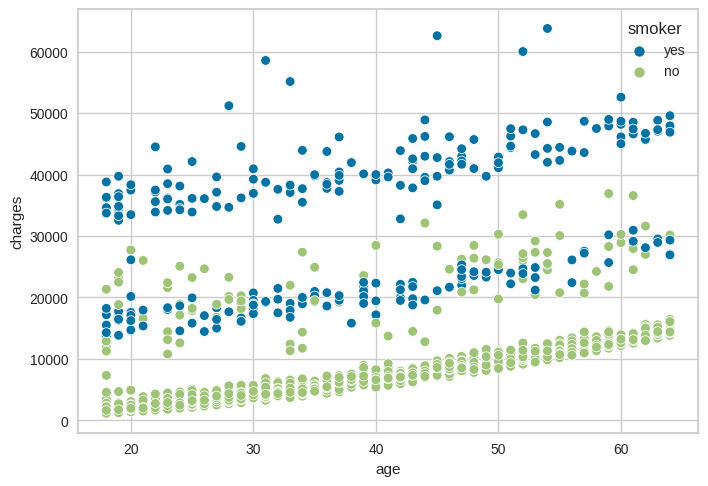

In [7]:
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')

<Axes: xlabel='bmi', ylabel='charges'>

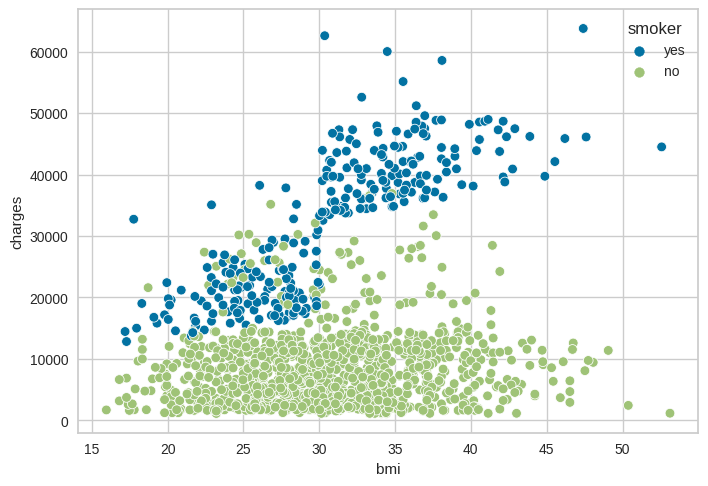

In [8]:
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')

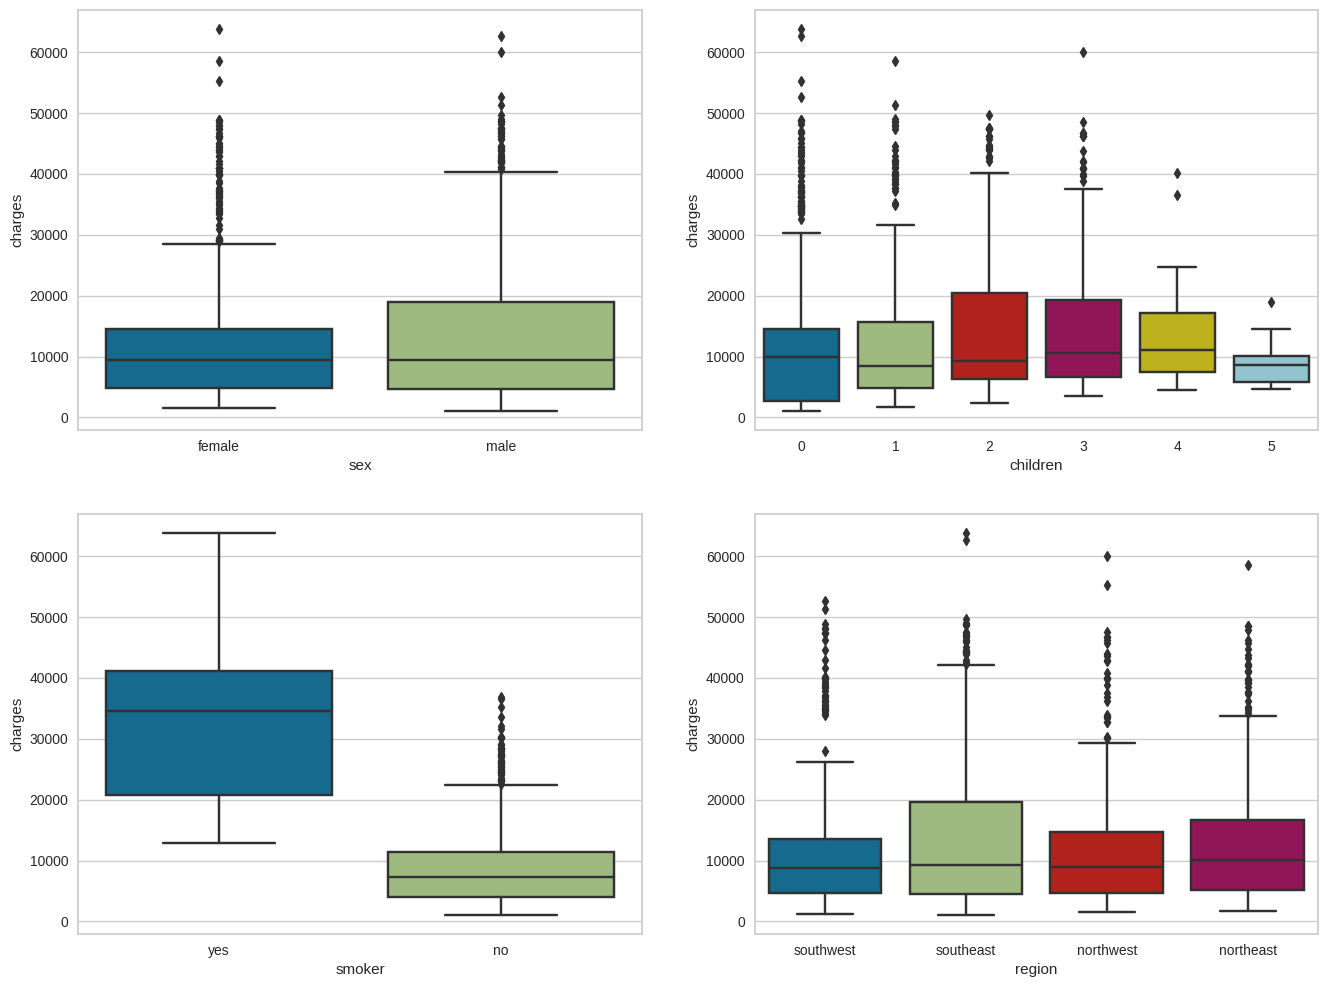

In [9]:
cat_plot_cols = ['sex', 'children', 'smoker', 'region']

f, axes = plt.subplots(nrows=2, ncols = 2, figsize=(16,12))
for col,ax in zip(cat_plot_cols, axes.flatten()):
    sns.boxplot(x=col, y='charges', data=df, ax=ax)

/tmp/ipykernel_4946/1580164805.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfc = df.corr()


<Axes: >

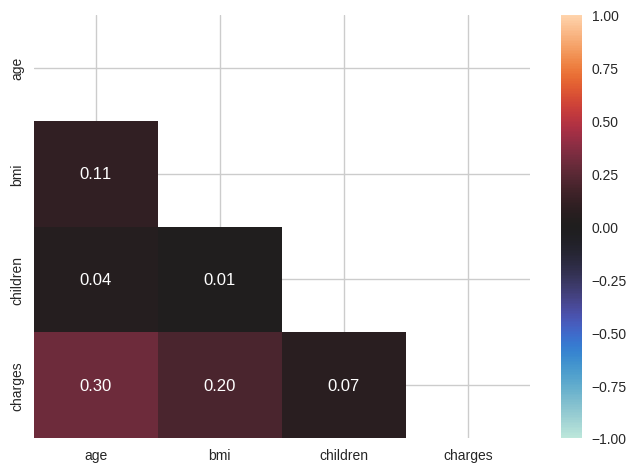

In [10]:
dfc = df.corr()
mask = np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dfc, annot=True, fmt='.2f', center=0, vmax=1, vmin=-1, mask=mask)

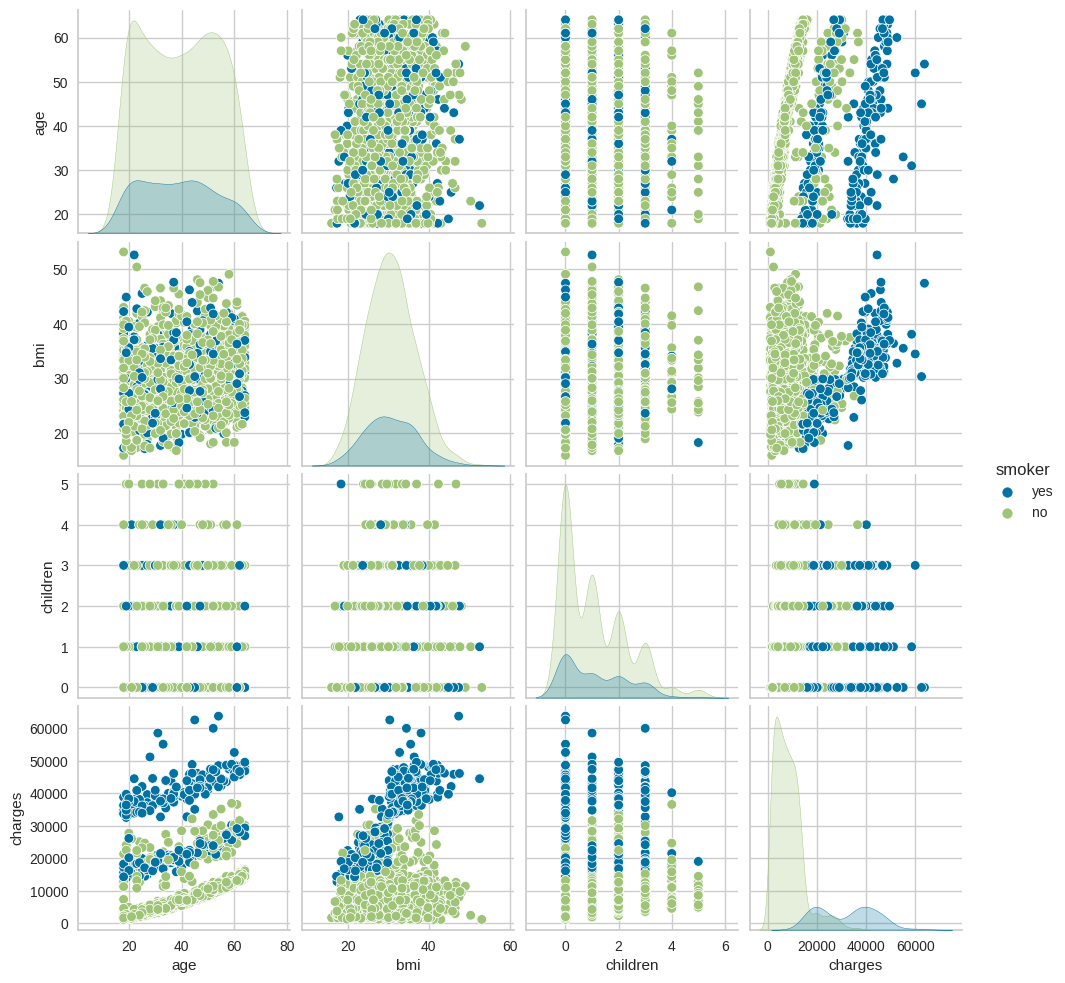

In [11]:
sns.pairplot(df, hue='smoker')

# Modeling

Definindo colunas e separando as features do target para a criação do modelo.

In [42]:
NUMERICAL_FEATURE = ['age', 'bmi', 'children']
CATEGORICAL_FEATURES = ['sex', 'smoker', 'region']

FEATURES =  NUMERICAL_FEATURE + CATEGORICAL_FEATURES

TARGET = 'charges'

Separando os dados em treino e teste.

In [43]:
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

Criando os transformadores para normalizar as colunas numericas e dummyzar as colunas categoricas para fazer o preprocessamento dos dados.
Colocamos um imputer no "numerical_transformer" para no caso de existirem valores faltantes.

In [44]:
categorical_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
numerical_transformer = MinMaxScaler()
model = DummyRegressor()

In [45]:
pipe = PipelineClass(NUMERICAL_FEATURE, CATEGORICAL_FEATURES, model, categorical_transformer, numerical_transformer)
#pipe.imputer()
model_pipeline = pipe.get_pipeline().fit(X_train, y_train)

In [46]:
pipe.get_preprocessor().fit_transform(X_train)

,encoder__sex_male,encoder__smoker_yes,encoder__region_northeast,encoder__region_northwest,encoder__region_southeast,encoder__region_southwest,scaler__age,scaler__bmi,scaler__children
1068,1.0,0.0,0.0,1.0,0.0,0.0,0.978261,0.153349,0.2
1018,0.0,0.0,0.0,1.0,0.0,0.0,0.782609,0.534167,0.6
995,0.0,0.0,1.0,0.0,0.0,0.0,0.456522,0.196798,0.6
1248,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.641916,0.0
549,0.0,1.0,0.0,0.0,1.0,0.0,0.543478,0.813559,0.0
...,...,...,...,...,...,...,...,...,...
884,1.0,0.0,0.0,1.0,0.0,0.0,0.152174,0.288808,0.8
515,1.0,0.0,0.0,0.0,0.0,1.0,0.869565,0.531073,0.0
695,0.0,0.0,0.0,1.0,0.0,0.0,0.173913,0.651735,0.0
454,1.0,0.0,0.0,0.0,1.0,0.0,0.304348,0.822437,0.4


Colocando o "preprocessor" no pipeline juntamente com o modelo.

In [17]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker', 'region']),
                                                 ('scaler',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('model', DummyRegressor())])

In [18]:
# Atributo named_steps do pipeline retorna os preprocessadores do pipeline.
model_pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('encoder',
                                  OneHotEncoder(drop='if_binary',
                                                handle_unknown='ignore',
                                                sparse_output=False),
                                  ['sex', 'smoker', 'region']),
                                 ('scaler',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', MinMaxScaler())]),
                                  ['age', 'bmi', 'children'])]),
 'model': DummyRegressor()}

Selecionando os modelos e treinando o GridSearch para avalia-los.

In [19]:
params = {
    'model': [
        DummyRegressor(),
        LinearRegression(),
        LassoCV(),
        RidgeCV(),
        RandomForestRegressor(random_state=2023),
        GradientBoostingRegressor(random_state=2023)
    ]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaler',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('model', DummyRegressor())]),
             param_grid={'model': [DummyRegressor(), LinearRegression(),
                                   LassoCV(), RidgeCV(),
                                   RandomForestRegressor(random_state=2023),
                                   GradientBoostingRegressor(random_state=2023)]},
             scoring='r2', verbose=1)

Acima, o GridSearch mostra que foram criados 5 folds para 6 candidatos, totalizando 30 ajustes de modelos.
Abaixo, com o atributo best_estimator_ podemos observar que o modelo com melhor performace foi o GradientBoostingRegressor.

In [20]:
grid_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker', 'region']),
                                                 ('scaler',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('model', GradientBoostingRegressor(random_state=2023))])

Abaixo, criamos um dataframe para rankear os modelos de acordo com sua performace, baseado na média do teste e no desvio padrão do teste, podendo observar que o GradientBoostingRegressor apresentou a maior média entre os 6 modelos, e um desvio padrão razoavel

In [21]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).drop(columns=['params'], axis=1).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model,mean_test_score,std_test_score
rank_test_score,,,
1,GradientBoostingRegressor(random_state=2023),0.849397,0.007451
2,RandomForestRegressor(random_state=2023),0.840734,0.006018
3,LassoCV(),0.743770,0.016151
4,RidgeCV(),0.743745,0.016170
5,LinearRegression(),0.743625,0.016148
6,DummyRegressor(),-0.001045,0.001007


Como o GradientBoostingRegressor foi o modelo de melhor performace, resolvemos testar alguns hiperparêmetros para avaliar verificar se há melhora de performace.
Dessa vêz obtemos 5 folgs para 36 candidatos totalizando 180 ajustes de modelo.

In [22]:
model = GradientBoostingRegressor(random_state=2023)
pipe = PipelineClass(NUMERICAL_FEATURE, CATEGORICAL_FEATURES, model, categorical_transformer, numerical_transformer)
model_pipeline = pipe.get_pipeline().fit(X_train, y_train)

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1., .8]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=2023))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [300, 400, 500],
                         'model__subsample': [1.0, 0.8]},
             scoring='r2', verbose=1)

Novamente criamos um dataframe para observarmos melhor qual o melhor modelo de acordo com cada hiperparâmetro utilizado.

In [23]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858106,0.006196
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857875,0.006378
3,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857039,0.006534
4,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.856653,0.006464
5,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.856394,0.005296
6,0.01,3,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.855619,0.006343
7,0.01,4,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.854024,0.006306
8,0.01,4,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.853739,0.007310
9,0.01,4,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.853535,0.005850


Faremos agora um pipeline do nosso melhor modelo.

In [24]:
model_pipeline = grid_model.best_estimator_

Utilizando a função criada no começo do notebook para a pegar as métricas do modelo.

In [25]:
y_pred = model_pipeline.predict(X_test)
get_metrics(y_test, y_pred)

{'R2': 0.8666382425293451,
 'MAE': 2497.107409450538,
 'MAPE': 0.30132669169719795,
 'RMSE': 4190.511790929283}

Plotando gráficos para avaliar a distribuição do dataframe.

<Axes: xlabel='charges'>

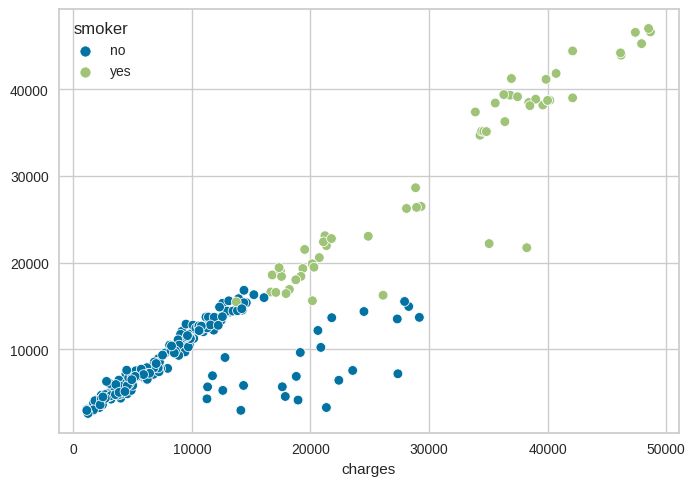

In [26]:
sns.scatterplot(x=y_test, y=y_pred, hue=X_test.smoker)

Podemoa avaliar a importância de cada feature utilizando o gráfico de barras e o atributo feature_importances_.

<Axes: >

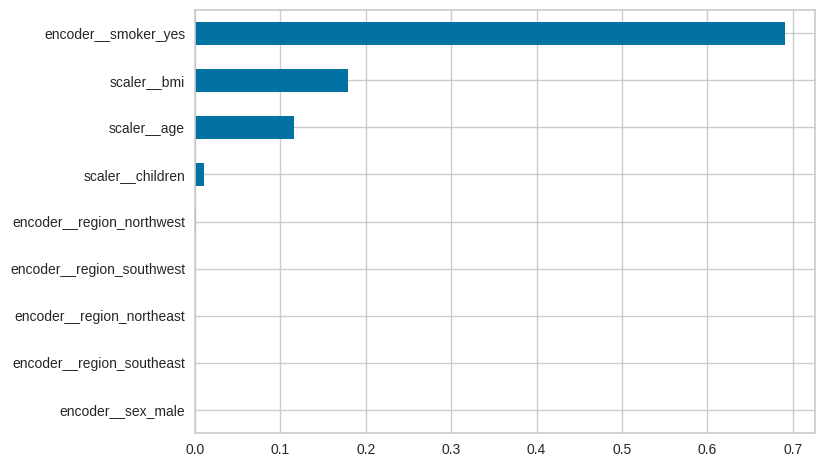

In [27]:
importances = pd.Series (
    data = model_pipeline.named_steps['model'].feature_importances_,
    index = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)
    

importances.sort_values().plot.barh()

In [28]:
NUMERICAL_FEATURE = ['age', 'bmi', 'children']
CATEGORICAL_FEATURES = ['smoker']

FEATURES =  NUMERICAL_FEATURE + CATEGORICAL_FEATURES
TARGET = 'charges'

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

In [29]:
pipe = PipelineClass(NUMERICAL_FEATURE, CATEGORICAL_FEATURES, model, categorical_transformer, numerical_transformer)
model_pipeline = pipe.get_pipeline().fit(X_train, y_train)

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1., .8]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_model.fit(X_train, y_train)

df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858339,0.005844
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857689,0.005985
3,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857419,0.006578
4,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857347,0.006403
5,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.856735,0.005107
6,0.01,3,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.856103,0.006204
7,0.01,4,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.854481,0.005906
8,0.01,4,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.854272,0.006888
9,0.01,4,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.854227,0.006909


Selecionando o modelo com melhor performace com o atributo "best_estimator_"

In [38]:
model_pipeline = grid_model.best_estimator_
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['smoker']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=400,
                                           random_state=2023, subsample=0.8))])

Criando uma series para fazer a seleção de features e plotando um gráfico.

<Axes: >

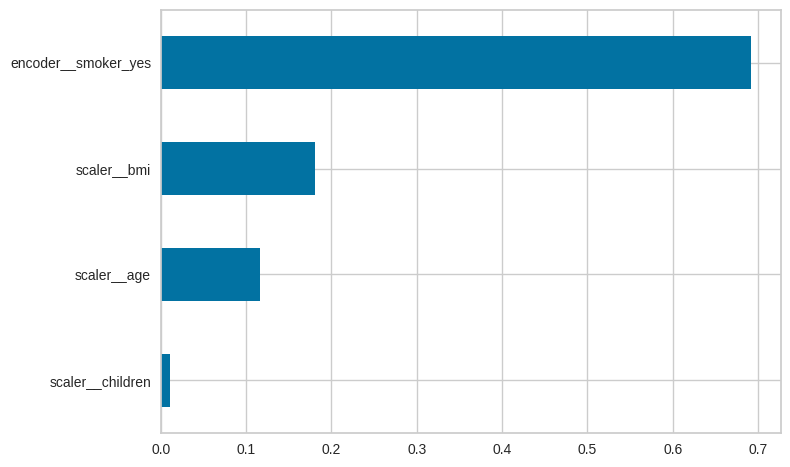

In [36]:
importances = pd.Series (
    data = model_pipeline.named_steps['model'].feature_importances_,
    index = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)
    

importances.sort_values().plot.barh()

In [37]:
y_pred = model_pipeline.predict(X_test)
get_metrics(y_test, y_pred)

{'R2': 0.8657758682894271,
 'MAE': 2490.5288905102443,
 'MAPE': 0.29838871949221424,
 'RMSE': 4204.038780315766}

Com base no que foi aprendido na aula, criei uma classe para gerar pipelines chamada PipelineClasse. No codigo abaixo, utilizo essa classe para rodar modelos e colocar suas métricas em dicionarios, para convertê-los em um dataframe para comparação.

In [33]:
models = [
        DummyRegressor(),
        LinearRegression(),
        LassoCV(),
        RidgeCV(),
        RandomForestRegressor(random_state=2023),
        GradientBoostingRegressor(random_state=2023)
    ]


modelos = {'models':[], 'R2':[], 'MAE':[], 'MAPE':[], 'RMSE':[]}

for model in models:
    pipe = PipelineClass(NUMERICAL_FEATURE, CATEGORICAL_FEATURES, model, categorical_transformer, numerical_transformer)
    model_pipe = pipe.get_pipeline().fit(X_train, y_train)
    y_pred = model_pipe.predict(X_test)
    modelos['models'].append(f"{model}")
    metricas = get_metrics(y_test, y_pred)
    for metrica in metricas:
        if metrica == 'R2':
            modelos['R2'].append(metricas[metrica])
        if metrica == 'MAE':
            modelos['MAE'].append(metricas[metrica])
        if metrica == 'MAPE':
            modelos['MAPE'].append(metricas[metrica])
        if metrica == 'RMSE':
            modelos['RMSE'].append(metricas[metrica])

pd.DataFrame(modelos)

,models,R2,MAE,MAPE,RMSE
0,DummyRegressor(),-0.000013,8793.954986,1.441813,11475.040466
1,LinearRegression(),0.758948,4042.196080,0.396185,5633.868517
2,LassoCV(),0.758980,4038.957879,0.395174,5633.499837
3,RidgeCV(),0.758978,4041.523540,0.395894,5633.519138
4,RandomForestRegressor(random_state=2023),0.828280,2674.839840,0.324324,4755.118727
5,GradientBoostingRegressor(random_state=2023),0.859149,2464.607234,0.272276,4306.574048


In [34]:
with open('../models/model.pkl', 'wb') as file_odel:
    pickle.dump(model_pipeline, file_odel)
